# Component-wise Dirichlet BC
Author: Jørgen S. Dokken

In this section, we will learn how to prescribe Dirichlet boundary conditions on a component of your unknown $u_h$.
We will illustrate the problem using a vector element. However, the method generalizes to any mixed element.

We will use a slightly modified version of [the linear elasticity demo](./../chapter2/linearelasticity_code), namely

$$
-\nabla \cdot \sigma (u) = f\quad \text{in } \Omega,
$$

$$
\sigma \cdot n = 0 \quad \text{on } \partial \Omega_N,
$$

$$
u= 0\quad \text{at } \partial\Omega_{D},
$$

$$
u_x=0 \quad \text{at } \partial\Omega_{Dx},
$$

$$
\sigma(u)= \lambda \mathrm{tr}(\epsilon(u))I + 2 \mu \epsilon(u), \qquad \epsilon(u) = \frac{1}{2}\left(\nabla u + (\nabla u )^T\right).
$$
We will consider a two dimensional box spanning $[0,L]\times[0,H]$, where
$\partial\Omega_N$ is the left and right side of the beam, $\partial\Omega_D$ the bottom of the  beam, while $\partial\Omega_{Dx}$ is the right side of the beam.
We will prescribe a displacement $u_x=0$ on the right side of the beam, while the beam is being deformed under its own weight. The sides of the box are traction free.

In [1]:
import pyvista
import numpy as np
from mpi4py import MPI
from ufl import Identity, Measure, TestFunction, TrialFunction, dot, dx, inner, grad, nabla_div, sym
from dolfinx import default_scalar_type
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from dolfinx.fem.petsc import LinearProblem
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, locate_dofs_geometrical,
                         locate_dofs_topological)
from dolfinx.plot import vtk_mesh

L = 1
H = 1.3
lambda_ = 1.25
mu = 1
rho = 1
g = 1

As in the previous demos, we define our mesh and function space.

In [2]:
mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0, 0], [L, H]]), [30, 30], cell_type=CellType.triangle)
V = functionspace(mesh, ("Lagrange", 1, (mesh.geometry.dim , )))

## Boundary conditions
As we would like to clamp the boundary at $x=0$, we do this by using a marker function, we use `dolfinx.fem.locate_dofs_geometrical` to identify the relevant degrees of freedom.

In [3]:
def clamped_boundary(x):
    return np.isclose(x[1], 0)


u_zero = np.array((0,) * mesh.geometry.dim, dtype=default_scalar_type)
bc = dirichletbc(u_zero, locate_dofs_geometrical(V, clamped_boundary), V)

Next we would like to constrain the $x$-component of our solution at $x=L$ to $0$. We start by creating the sub space only containing the $x$
-component.

Next, we locate the degrees of freedom on the top boundary. However, as the boundary condition is in a sub space of our solution, we need to supply both the parent space $V$ and the sub space $V_0$ to `dolfinx.locate_dofs_topological`.

In [4]:
def right(x):
    return np.logical_and(np.isclose(x[0], L), x[1] < H)

In [5]:
boundary_facets = locate_entities_boundary(mesh, mesh.topology.dim - 1, right)
boundary_dofs_x = locate_dofs_topological(V.sub(0), mesh.topology.dim - 1, boundary_facets)

We can now create our Dirichlet condition

In [6]:
bcx = dirichletbc(default_scalar_type(0), boundary_dofs_x, V.sub(0))
bcs = [bc, bcx]

As we want the traction $T$ over the remaining boundary to be $0$, we create a `dolfinx.Constant`

In [7]:
T = Constant(mesh, default_scalar_type((0, 0)))

We also want to specify the integration measure $\mathrm{d}s$, which should be the integral over the boundary of our domain. We do this by using `ufl`, and its built in integration measures

In [8]:
ds = Measure("ds", domain=mesh)

## Variational formulation
We are now ready to create our variational formulation in close to mathematical syntax, as for the previous problems.

In [9]:
def epsilon(u):
    return sym(grad(u))


def sigma(u):
    return lambda_ * nabla_div(u) * Identity(len(u)) + 2 * mu * epsilon(u)


u = TrialFunction(V)
v = TestFunction(V)
f = Constant(mesh, default_scalar_type((0, -rho * g)))
a = inner(sigma(u), epsilon(v)) * dx
L = dot(f, v) * dx + dot(T, v) * ds

## Solve the linear variational problem
As in the previous demos, we assemble the matrix and right hand side vector and use PETSc to solve our variational problem

In [10]:
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

## Visualization

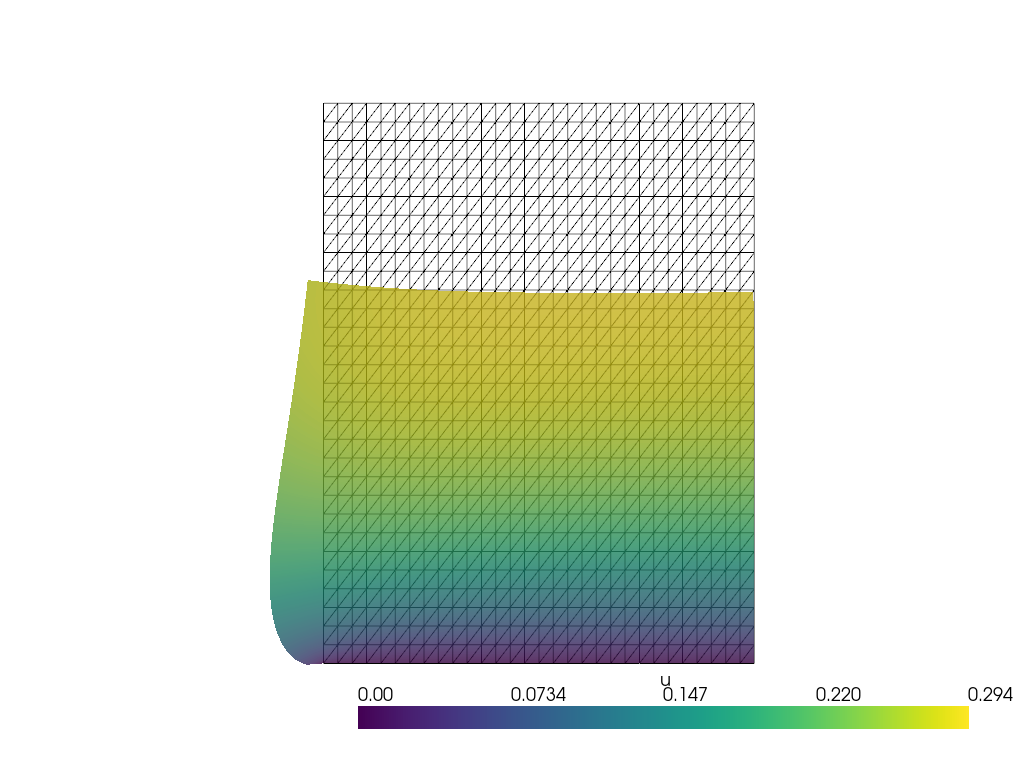

In [11]:
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, x = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

# Attach vector values to grid and warp grid by vector

vals = np.zeros((x.shape[0], 3))
vals[:, :len(uh)] = uh.x.array.reshape((x.shape[0], len(uh)))
grid["u"] = vals
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, opacity=0.8)
p.view_xy()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    fig_array = p.screenshot(f"component.png")